In [1]:
from __future__ import print_function
from __future__ import division

import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)
    
from utils.plots import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from  kernelfuzzy.fuzzyset import FuzzySet
from kernelfuzzy.fuzzysystem import get_rule_antecedents,plot_membership_fun
from  kernelfuzzy.fuzzification import FuzzyData, NonSingletonFuzzifier
from kernelfuzzy.kernels import gram_matrix_KBF_kernel,KBFkernel,NonSingletonKernel
from sklearn.datasets.samples_generator import make_classification
from sklearn.datasets import make_moons, make_circles,make_blobs,load_digits
from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from kernelfuzzy.kernels import nonsingleton_gaussian_kernel, gram_matrix_nonsingleton_gaussian_kernel
from sklearn.metrics import accuracy_score
import skfuzzy as fuzz # for FCM
import pickle

This notebook ...

##  Datasets


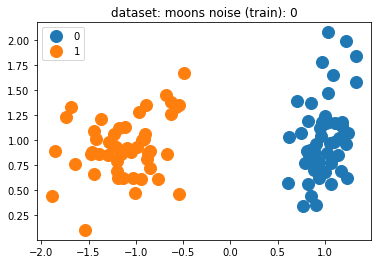

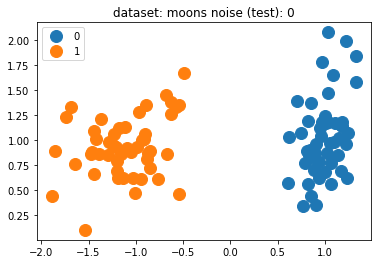

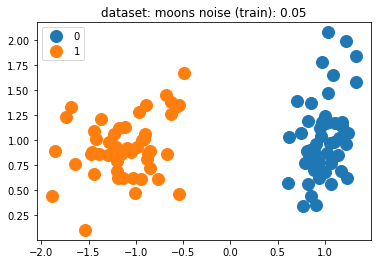

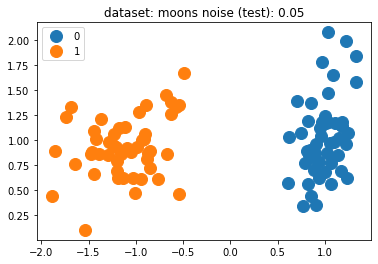

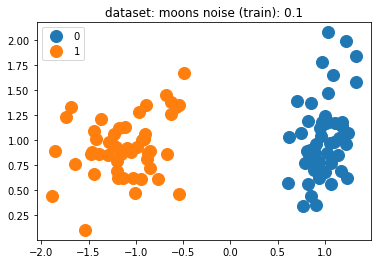

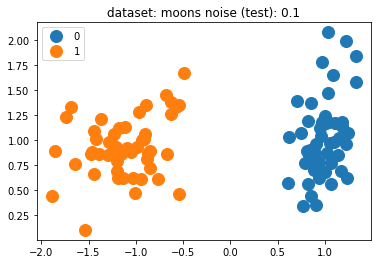

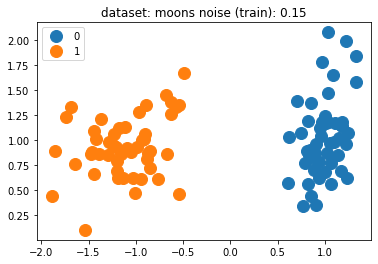

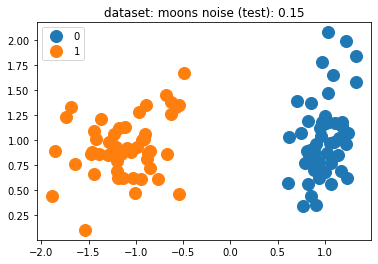

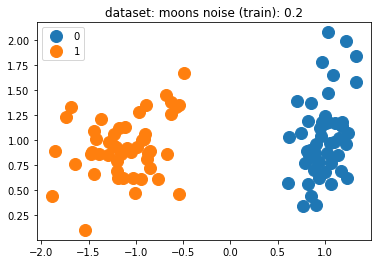

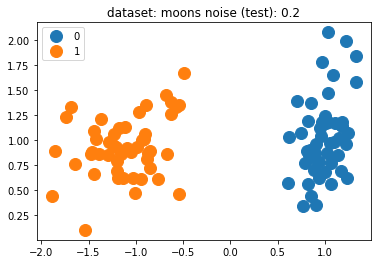

In [2]:
#noisy train - noisy test
noise_level=[0,0.05, 0.1, 0.15, 0.2]

for noise in noise_level:
    X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
    X_test, y_test = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
    df=pd.DataFrame(data=X,columns=['x1','x2'])
    df['y']=y
    
    df_test=pd.DataFrame(data=X_test,columns=['x1','x2'])
    df_test['y']=y_test
    
    plot_dataset(df,"moons noise (train): "+str(noise))
    plot_dataset(df_test,"moons noise (test): "+str(noise))
    







## Membership functions from  LMFCM

In [ ]:
#cluster each variable independently per category
#class 0
colnames=['x1','x2']
n_centers_per_column=[3,3]
plot_mf_FCM(df.loc[df['y']==0], colnames, n_centers_per_column)

#class 1
plot_mf_FCM(df.loc[df['y']==1], colnames, n_centers_per_column)


## Membership functions from SVM with nonsingleton kernel on fuzzy sets

In [ ]:
  
pipe = Pipeline([
    ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
    ('NSKernel', NonSingletonKernel()),
    ('svm', NuSVC())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('Fuzzifier__std_proportion',np.arange(0.01,np.std(X),0.1)),
    ('NSKernel__param', 2.0**np.arange(-20,20)),
    ('svm__kernel', ['precomputed']),
    ('svm__nu', np.arange(0.05,0.2,0.05)),
    #('svm__C', 2.0**np.arange(-5,20))
])

#model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model_SVM_NS = RandomizedSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1,n_iter=100)
model_SVM_NS.fit(X, y)
    
print('Model parameters : {}'.format(model_SVM_NS.best_params_))
print('support vectors: {}'.format( model_SVM_NS.best_estimator_['svm'].support_))


In [ ]:
#rule generation
percentage_x_plot=0
gamma=model_SVM_NS.best_params_['NSKernel__param']
std_proportion=model_SVM_NS.best_params_['Fuzzifier__std_proportion']
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)

plt.title("SVM + nonsingleton kernel")
plot_decision_function_kernel_Nonsingleton(X,  y, model_SVM_NS.best_estimator_['svm'], std_proportion,gamma, type=0)

plt.title("interpretation as NSFS")
plot_decision_function_kernel_KBF(X,  y, model_SVM_NS.best_estimator_['svm'], std_proportion,gamma, type=0)

rules_antecedents=get_rule_antecedents(model_SVM_NS.best_estimator_['svm'], fuzzy_data, gamma)

index_sv_class_0=model_SVM_NS.best_estimator_['svm'].support_[0:model_SVM_NS.best_estimator_['svm'].n_support_[1]-1]
print(index_sv_class_0)
index_sv_class_1=np.setdiff1d(model_SVM_NS.best_estimator_['svm'].support_,index_sv_class_0)
print(index_sv_class_1)

rules_antecedents_class_0=rules_antecedents[0:model_SVM_NS.best_estimator_['svm'].n_support_[1],:]
rules_antecedents_class_1=rules_antecedents[model_SVM_NS.best_estimator_['svm'].n_support_[1]::,:]


#class0
print("Membership function Rule antecedents class 0")

plot_membership_fun(rules_antecedents_class_0,X[index_sv_class_0,:],percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[index_sv_class_0,:],X[index_sv_class_0,:],percentage_x_plot)


print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents_class_0,X[index_sv_class_0,:],percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[index_sv_class_0,:],X[index_sv_class_0,:],percentage_x_plot)

#class1

print("Membership function Rule antecedents class 1")

plot_membership_fun(rules_antecedents_class_1,X[index_sv_class_1,:],percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[index_sv_class_1,:],X[index_sv_class_1,:],percentage_x_plot)


print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents_class_1,X[index_sv_class_1,:],percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[index_sv_class_1,:],X[index_sv_class_1,:],percentage_x_plot)


In [ ]:
#clustering the fuzzy numbers
colnames=['x1','x2']
n_centers_per_column=[3,3]
plot_mf_FCM(df.iloc[index_sv_class_0], colnames, n_centers_per_column)
plot_mf_FCM(df.iloc[index_sv_class_1], colnames, n_centers_per_column)


In [ ]:
# using KBF kernel
pipe = Pipeline([
    ('Fuzzifier', NonSingletonFuzzifier(constant_std=True)),
    ('Kernel', KBFkernel()),
    ('svm', NuSVC())])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('Fuzzifier__std_proportion',np.arange(0.01,np.std(X),0.1)),
    ('Kernel__param', 2.0**np.arange(-20,-1)),
    ('svm__kernel', ['precomputed']),
    ('svm__nu', np.arange(0.1,0.3,0.1)),
])


#model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model_SVM_KBF = RandomizedSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1,n_iter=100)
model_SVM_KBF.fit(X, y)

print('Model parameters : {}'.format(model_SVM_KBF.best_params_))
print('support vectors: {}'.format( model_SVM_KBF.best_estimator_['svm'].support_))


In [ ]:
percentage_x_plot=0
gamma=model_SVM_KBF.best_params_['Kernel__param']
std_proportion=model_SVM_KBF.best_params_['Fuzzifier__std_proportion']
fuzzy_data=NonSingletonFuzzifier( std_proportion=std_proportion, constant_std=True ).transform(X,y)

plt.title("interpretation as NSFS")
plot_decision_function_kernel_KBF(X,  y, model_SVM_KBF.best_estimator_['svm'], std_proportion,gamma, type=0)

###
rules_antecedents=get_rule_antecedents(model_SVM_KBF.best_estimator_['svm'], fuzzy_data, gamma)

index_sv_class_0=model_SVM_KBF.best_estimator_['svm'].support_[0:model_SVM_KBF.best_estimator_['svm'].n_support_[1]-1]
print(index_sv_class_0)
index_sv_class_1=np.setdiff1d(model_SVM_KBF.best_estimator_['svm'].support_,index_sv_class_0)
print(index_sv_class_1)

rules_antecedents_class_0=rules_antecedents[0:model_SVM_KBF.best_estimator_['svm'].n_support_[1],:]
rules_antecedents_class_1=rules_antecedents[model_SVM_KBF.best_estimator_['svm'].n_support_[1]::,:]

#class0
print("Membership function Rule antecedents class 0")

plot_membership_fun(rules_antecedents_class_0,X[index_sv_class_0,:],percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[index_sv_class_0,:],X[index_sv_class_0,:],percentage_x_plot)


print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents_class_0,X[index_sv_class_0,:],percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[index_sv_class_0,:],X[index_sv_class_0,:],percentage_x_plot)

#class1

print("Membership function Rule antecedents class 1")

plot_membership_fun(rules_antecedents_class_1,X[index_sv_class_1,:],percentage_x_plot)
print("Membership function of fuzzy numbers linked to rule antecedents")
plot_membership_fun(fuzzy_data[index_sv_class_1,:],X[index_sv_class_1,:],percentage_x_plot)


print("plot of vectors of fuzzy sets linked to rule antecedents")
plot_fuzzydata(rules_antecedents_class_1,X[index_sv_class_1,:],percentage_x_plot)
print("plot of vectors of fuzzy sets linked to the fuzzy numbers linked to rule antecedents")
plot_fuzzydata(fuzzy_data[index_sv_class_1,:],X[index_sv_class_1,:],percentage_x_plot)

###


In [ ]:
#clustering the fuzzy numbers
colnames=['x1','x2']
n_centers_per_column=[3,3]

plot_mf_FCM(df.iloc[index_sv_class_0], colnames, n_centers_per_column)
plot_mf_FCM(df.iloc[index_sv_class_1], colnames, n_centers_per_column)
